### Neurophysiology and Biophysics - Practical course WS 2024/25
__Cornelia Kopp-Scheinpflug & Kay Thurley__

# Miniproject: Gap junctions and network synchorization

In this notebook we simulate a small network of electrically coupled Drosophila motoneurons. The network shows different regimes of synchrony depending on the coupling strength of the GAP junctions, which is supposed to underly the insect's flight. The model was used in Hürkey et al. (2023) and adapted by Kay Thurley (2024).


_Requirements:_ You will need Python 3 and the packages Numpy, Matplotlib and BRIAN2.


We start by importing the relevant packages.

In [2]:
import numpy as np
from brian2 import *
import sys, os
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())
import json

from utils.brianutils import units
from utils.random_initial_conditions import *
from utils.sim import *
from utils.convert_ggap_ccs import *
from utils.spiketime_analysis_helper import *

saving/loading sims from:  sim_results/


Then we define load some parameters and define the neuron.

In [3]:
md_SNL = json.load(open("cfg/Berger_SNL.json"))
md_SNIC = json.load(open("cfg/Berger_SNIC.json"))
ggap_hom = np.load('cfg/ggap_hom.npy')*nS
ggap_het = np.load('cfg/ggap_het.npy')*nS

In [4]:
def phase_histogram(SpM, idx_ref, idx_target, bins=30, ax=None, title=None):
    """
    Compute and plot phase histogram of target neuron's spikes 
    relative to reference neuron's cycle.
    
    Parameters
    ----------
    SpM : SpikeMonitor
        Brian2 SpikeMonitor object with attributes `.t` (times) and `.i` (indices).
    idx_ref : int
        Index of reference neuron (e.g., MN4).
    idx_target : int
        Index of target neuron (e.g., MN5).
    bins : int
        Number of histogram bins.
    ax : matplotlib axis or None
        If provided, plot on this axis. Otherwise, create a new one.
        
    Returns
    -------
    phases : np.ndarray
        Array of phase values (wrapped to [-0.5, 0.5)).
    """

    # Extract spikes for each neuron
    t_ref = np.array(SpM.t[SpM.i == idx_ref])
    t_tar = np.array(SpM.t[SpM.i != idx_ref])
    if len(t_ref) < 2 or len(t_tar) == 0:
        raise ValueError("Not enough spikes to compute phase relationship.")

    phases = []
    for i in range(len(t_ref) - 1):
        tA, tA_next = t_ref[i], t_ref[i + 1]
        cycle_duration = tA_next - tA
        mask = (t_tar >= tA - 0.5 * cycle_duration) & (t_tar < tA_next + 0.5 * cycle_duration)
        relevant_B = t_tar[mask]

        for tB in relevant_B:
            phi = (tB - tA) / cycle_duration
            # Wrap to [-0.5, 0.5)
            phi = ((phi + 0.5) % 1.0) - 0.5
            phases.append(phi)

    phases = np.array(phases)

    # --- Plotting ---
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 3))

    counts, edges = np.histogram(phases, bins=bins, range=(-0.5, 0.5))
    counts = counts / counts.sum() * 100  # convert to percentage

    ax.bar((edges[:-1] + edges[1:]) / 2, counts, width=1/bins, color='royalblue', edgecolor='black')
    ax.set_xlabel(f'Phase (φ)', fontsize=15)
    ax.set_ylabel('Occurrence %', fontsize=15)
    # set right and top spiine invisible
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(-0.5, 0.5)
    ax.set_xticks([-0.5, 0, 0.5])
    # for y ticks only show first and last ticks
    yticks = ax.get_yticks()
    if len(yticks) > 2:
        ax.set_yticks([yticks[0], yticks[-2]])

    # increase ticks font size
    ax.tick_params(axis='both', which='major', labelsize=15)
    # ax.grid(axis='y', linestyle='--', alpha=0.6)
    if title is not None:
        ax.set_title(title)

    plt.tight_layout()
    return phases

In [7]:
# noise free simulations
# ## case1: weak SNL
# used for figure 3B
np.random.seed(42)
N = 5
dur = 50*second
solver = 'heun'
dt = 100*us
couplings = [0.2, 0.3]
noise_stdev = 2e-8
# g_gap = ggap_hom
spm_array = []
for coupling in couplings:
    φs_chosen = np.array([0.9, 0.6, 0.5, 0.7, 0.8])
    initial_values = pick_initial_phase_SNL(φs_chosen)
    g_gap = cc2ggap(coupling)
    StM1, SpM1 = run_sim(N, md_SNL, g_gap, None, initial_values=initial_values,
                        dur=dur, σnoise=noise_stdev, solver=solver, dt=dt)
    spm_array.append(SpM1)

WARNING    'g_gap' is an internal variable of group 'synapses', but also exists in the run namespace with the value 2.156 * nsiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 50. s
14.5077 s (29%) simulated in 10s, estimated 24s remaining.
29.1863 s (58%) simulated in 20s, estimated 14s remaining.
43.7413 s (87%) simulated in 30s, estimated 4s remaining.
50. s (100%) simulated in 34s


WARNING    'g_gap' is an internal variable of group 'synapses', but also exists in the run namespace with the value 3.696 * nsiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 50. s
14.4473 s (28%) simulated in 10s, estimated 25s remaining.
25.6518 s (51%) simulated in 20s, estimated 19s remaining.
39.9579 s (79%) simulated in 30s, estimated 8s remaining.
50. s (100%) simulated in 37s


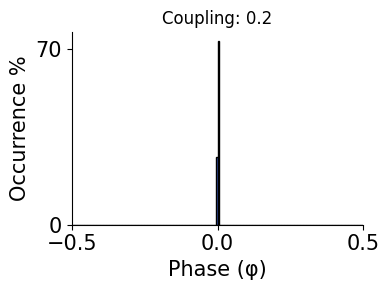

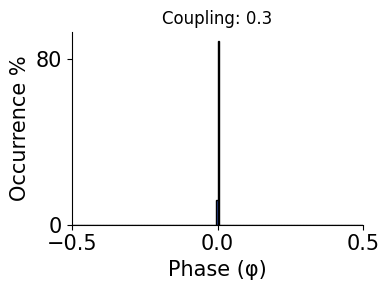

In [8]:

# Assuming SpM1 is your SpikeMonitor
for SpM1, coupling in zip(spm_array, couplings):
    phases = phase_histogram(SpM1, idx_ref=1, idx_target=4 ,bins = 200, title=f'Coupling: {coupling}')

In [20]:
raise

RuntimeError: No active exception to reraise

In [ ]:
# fig, ax = plt.subplots(5, 1, figsize=(8, 6))

# ts=StM1.t_
# per=np.median(np.diff(SpM1.t_[SpM1.i==0]))*second
# t_unit=ms
# N=5

# tstart = SpM1.t_[SpM1.i==0][SpM1.t_[SpM1.i==0]>2].min()
# m=(ts>tstart) & (ts<tstart+10)
# for i in range(N):
#     ax[i].plot(StM1.t[m]/ms-tstart*1000, StM1.v[i][m]/mV, c='k',lw=1)
#     ax[i].spines['left'].set_visible(False)
#     ax[i].set_ylabel('MN{}'.format(i+1))
#     ax[i].set_yticks([])
#     ax[i].set_ylim(-60,)
#     ax[i].spines['bottom'].set_visible(False)
#     ax[i].set_xticks([])
#     # shift = 2000
#     # ax[i].set_xlim(0 + shift,300 + shift)

#     for k in range(0,6):
#         ax[i].plot([k*per/t_unit,k*per/t_unit],[-50,10],'--',lw=0.5,c='darkgrey')


# ax[-1].set_xticks([0,100])
# ax[-1].spines['bottom'].set_bounds(0,100)
# ax[-1].spines['bottom'].set_visible(True)
# fig.text(0.17,0.0,'[ms]')

# ax[-1].spines['right'].set_visible(True)
# ax[-1].yaxis.tick_right()
# ax[-1].set_yticks([-50,0])
# fig.text(0.97,0.184,'[mV]')

In [ ]:
ggap2cc(ggap_hom)
cc2ggap(0.005)

43.33668342 * psiemens

In [ ]:
# Coupling coefficient
from utils.convert_ggap_ccs import *
print(ggap2cc(g_gap))

9.9999998488113e-08


0.07419999999999999 9.781099999999999
97069


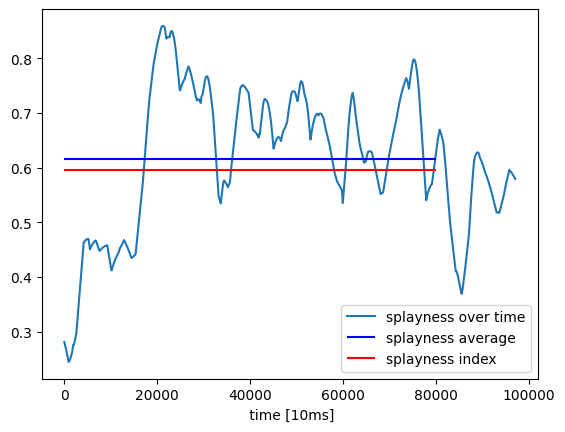

In [ ]:
from utils.spiketime_analysis_helper import *
# Splayness index
# Make sure tstart tend and dt have same units 
tmin, tmax = get_tminmax(SpM1)
print(tmin, tmax)
print(len(get_splayness(SpM1, tmin, tmax, 100e-6)[0]))
plt.plot(get_splayness(SpM1, tmin, tmax, 100e-6)[0], label ='splayness over time')
plt.hlines(np.mean(get_splayness(SpM1, tmin, tmax, 100e-6)[0]),0, 80000, color='b', label = 'splayness average')
plt.hlines(get_splayness(SpM1, tmin, tmax, 100e-6)[1],0, 80000, color='r', label = 'splayness index')
plt.xlabel(' time [10ms]')
plt.legend()
plt.show()

In [ ]:
from collections import defaultdict

def extract_splay_sequences(spike_ids, spike_times, N=5):
    pattern_times = defaultdict(list)

    # find indices where neuron 0 spikes
    zero_spike_indices = np.where(spike_ids == 0)[0]

    for idx in zero_spike_indices:
        # make sure there are at least N spikes after this 0
        if idx + N <= len(spike_ids):
            pattern = ''.join(str(x) for x in spike_ids[idx:idx + N])
            t = spike_times[idx]  # time of this pattern’s start (neuron 0 spike)
            pattern_times[pattern].append(t)

    return pattern_times

In [ ]:
patterns = extract_splay_sequences(SpM1.i, SpM1.t, N=5)

for p, times in patterns.items():
    print(f"Pattern {p} occurred {len(times)} times at times {np.round(times,3)}")


Pattern 04312 occurred 1 times at times [0.015]
Pattern 01243 occurred 2 times at times [0.276 2.902]
Pattern 02134 occurred 3 times at times [0.529 0.804 6.403]
Pattern 01423 occurred 8 times at times [1.05  1.307 1.584 1.854 2.106 2.373 2.637 3.15 ]
Pattern 04213 occurred 6 times at times [3.403 6.888 7.146 7.43  9.005 9.266]
Pattern 02413 occurred 3 times at times [3.662 3.906 8.784]
Pattern 02143 occurred 2 times at times [4.145 6.146]
Pattern 02410 occurred 1 times at times [4.387]
Pattern 03241 occurred 4 times at times [4.613 4.831 5.618 5.882]
Pattern 03214 occurred 2 times at times [5.089 5.362]
Pattern 02130 occurred 1 times at times [6.648]
Pattern 02314 occurred 3 times at times [7.739 8.011 8.273]
Pattern 01302 occurred 1 times at times [8.536]
Pattern 04231 occurred 2 times at times [9.528 9.781]


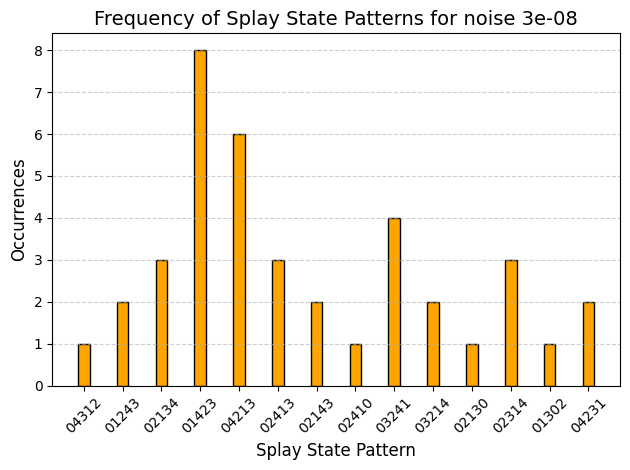

In [ ]:
# Assuming you've already run:
# patterns = extract_splay_sequences(SpM1.i, SpM1.t, N=5)

# Extract data for plotting
pattern_names = list(patterns.keys())
occurrences = [len(times) for times in patterns.values()]

# # Sort by most frequent pattern (optional, for clarity)
# sorted_idx = np.argsort(occurrences)[::-1]
# pattern_names = [pattern_names[i] for i in sorted_idx]
# occurrences = [occurrences[i] for i in sorted_idx]

# Plot
plt.figure()
plt.bar(pattern_names, occurrences, color='orange', edgecolor='black', width=0.3)
plt.xlabel('Splay State Pattern', fontsize=12)
plt.ylabel('Occurrences', fontsize=12)
plt.title(f'Frequency of Splay State Patterns for noise {noise_stdev}', fontsize=14)
plt.xticks(rotation=45, ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
SpM1.i

<spikemonitor_3.i: array([0, 4, 3, 1, 2, 3, 4, 0, 1, 2, 4, 3, 0, 2, 1, 3, 4, 0, 2, 1, 3, 4,
       2, 0, 1, 4, 2, 3, 0, 1, 4, 2, 3, 0, 1, 4, 2, 3, 0, 1, 4, 2, 3, 0,
       1, 4, 2, 3, 0, 1, 4, 2, 3, 0, 1, 4, 2, 3, 0, 1, 2, 4, 3, 0, 1, 4,
       2, 3, 0, 4, 2, 1, 3, 0, 2, 4, 1, 3, 0, 2, 4, 1, 3, 0, 2, 1, 4, 3,
       0, 2, 4, 1, 0, 3, 2, 4, 1, 0, 3, 2, 4, 1, 0, 3, 2, 1, 4, 0, 3, 2,
       1, 4, 0, 3, 2, 4, 1, 0, 3, 2, 4, 1, 3, 0, 2, 1, 4, 3, 0, 2, 1, 3,
       4, 0, 2, 1, 3, 0, 4, 2, 1, 3, 0, 4, 2, 1, 3, 0, 4, 2, 1, 3, 4, 0,
       2, 3, 1, 4, 0, 2, 3, 1, 4, 0, 2, 3, 1, 4, 2, 0, 1, 3, 0, 2, 4, 1,
       3, 0, 4, 2, 1, 3, 0, 4, 2, 1, 3, 0, 4, 2, 3, 1, 0, 4, 2, 3, 1],
      dtype=int32)>

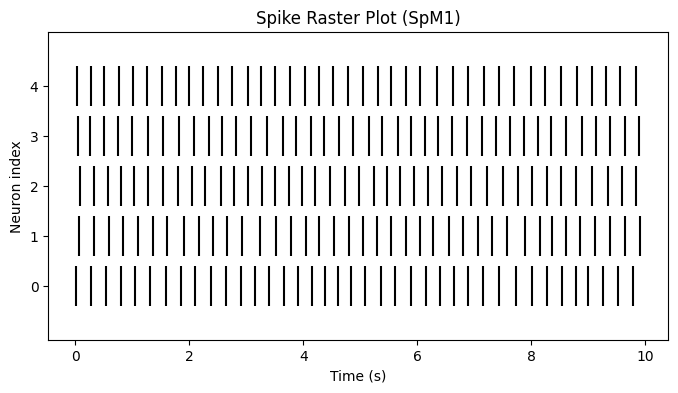

In [ ]:
# Extract spike times and indices
spike_times = SpM1.t / second   # convert to float seconds
spike_indices = SpM1.i

# Number of neurons (assuming indices start at 0)
n_neurons = int(max(spike_indices)) + 1

# Collect spikes per neuron
spike_trains = [spike_times[spike_indices == i] for i in range(n_neurons)]

# Plot raster
plt.figure(figsize=(8, 4))
plt.eventplot(spike_trains, colors='black', linelengths=0.8)

plt.xlabel("Time (s)")
plt.ylabel("Neuron index")
plt.title("Spike Raster Plot (SpM1)")
plt.yticks(range(n_neurons))
plt.show()


In [ ]:
raise

RuntimeError: No active exception to reraise